In [415]:
import os
import pandas as pd
from datetime import timedelta, datetime
import numpy as np
import matplotlib.pyplot as plt
import json
import warnings
import seaborn as sns
import requests
import Acquire as a
import Prepare as p
import yfinance as yf
#stats
from statsmodels.tsa.stattools import adfuller
import scipy.stats as stats
# modeling
import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing
np.random.seed(0)

# evaluate
from sklearn.metrics import mean_squared_error
from math import sqrt 
warnings.filterwarnings("ignore")

# plotting
import seaborn as sns 
import plotly.express as px
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# settings
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (16, 8)

In [21]:
df = a.get_apple_data()

In [22]:
df=p.clean_aapl(df)

In [23]:
df.head()

,Open,High,Low,Close,Adjusted_Close,Volume,month,day_of_week
2023-02-15,153.110,155.5000,152.88,155.33,155.330000,65532767.0,Feb,Wednesday
2023-02-14,152.120,153.7700,150.86,153.20,153.200000,61707573.0,Feb,Tuesday
2023-02-13,150.952,154.2600,150.92,153.85,153.850000,62199013.0,Feb,Monday
2023-02-10,149.460,151.3401,149.22,151.01,151.010000,57450708.0,Feb,Friday
2023-02-09,153.775,154.3300,150.42,150.87,150.640563,56007143.0,Feb,Thursday


In [24]:
df.month.value_counts()

Aug    511
Oct    507
Dec    506
Mar    504
Nov    492
Jun    491
May    487
Jan    486
Jul    485
Apr    475
Sep    465
Feb    452
Name: month, dtype: int64

In [328]:
df.Volume.mean()

31310165.437979866

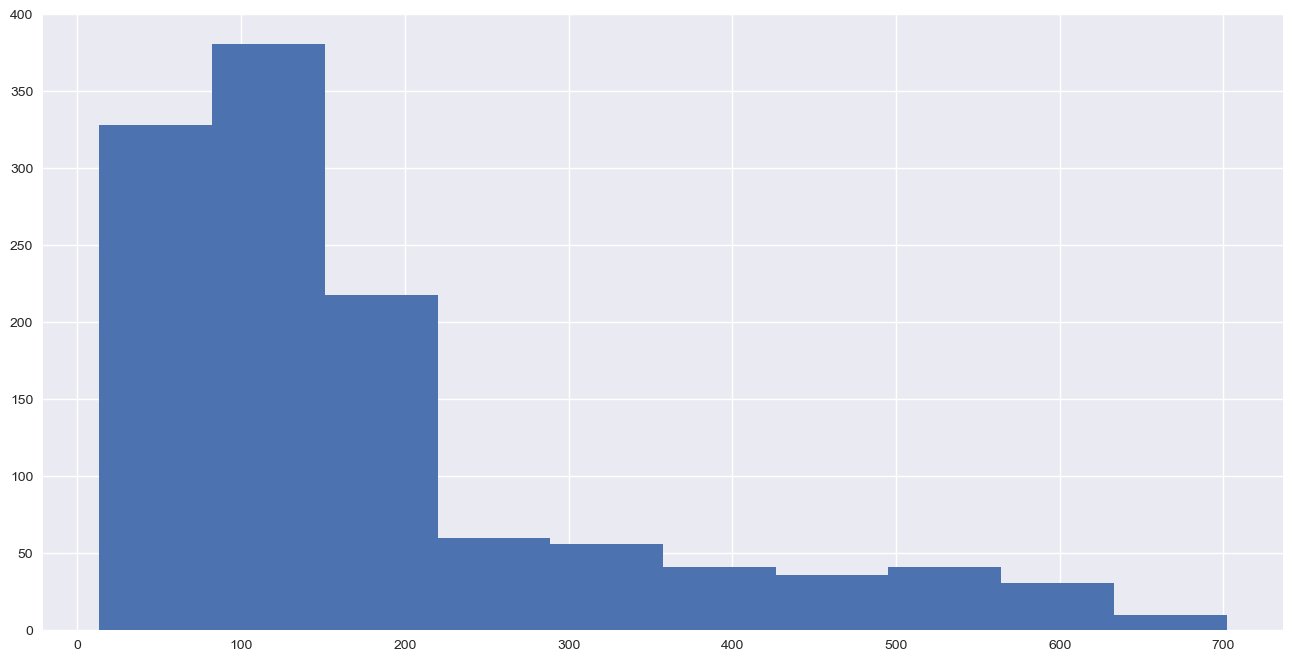

172.9670869384361


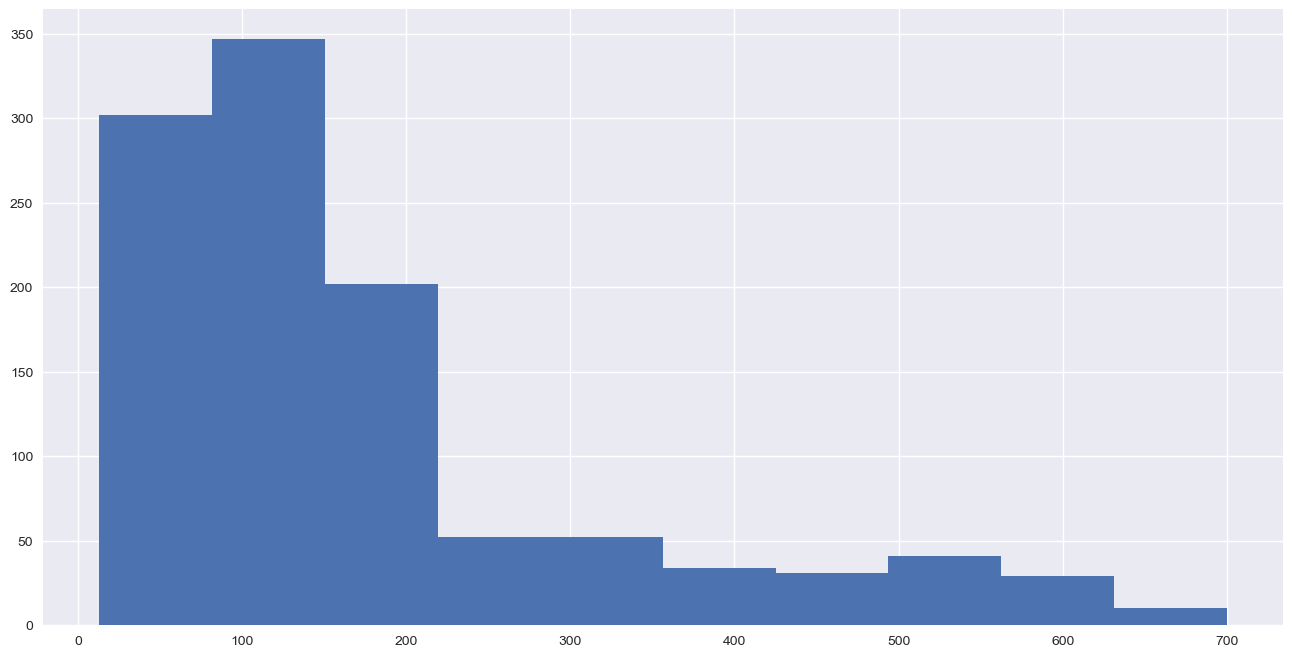

172.9355033636363


In [26]:
tues= df[df.day_of_week == 'Tuesday'].Close
tues.hist()
plt.show()

print(df[df.day_of_week == 'Tuesday'].Close.mean())

mon= df[df.day_of_week == 'Monday'].Close
mon.hist()
plt.show()

print(df[df.day_of_week == 'Monday'].Close.mean())

# Is there a relationship between the average count of trades on tuesday and average close prices on Tuesday?

In [327]:
α = .05

t, p = stats.ttest_ind(tues, mon, equal_var=False)

print("Is t < 0?", t < 0)

p/2 <α

print(' We fail to reject the null: There is no significant relationship between the avg stock prices closed on monday and tuesday')

Is t < 0? False


False

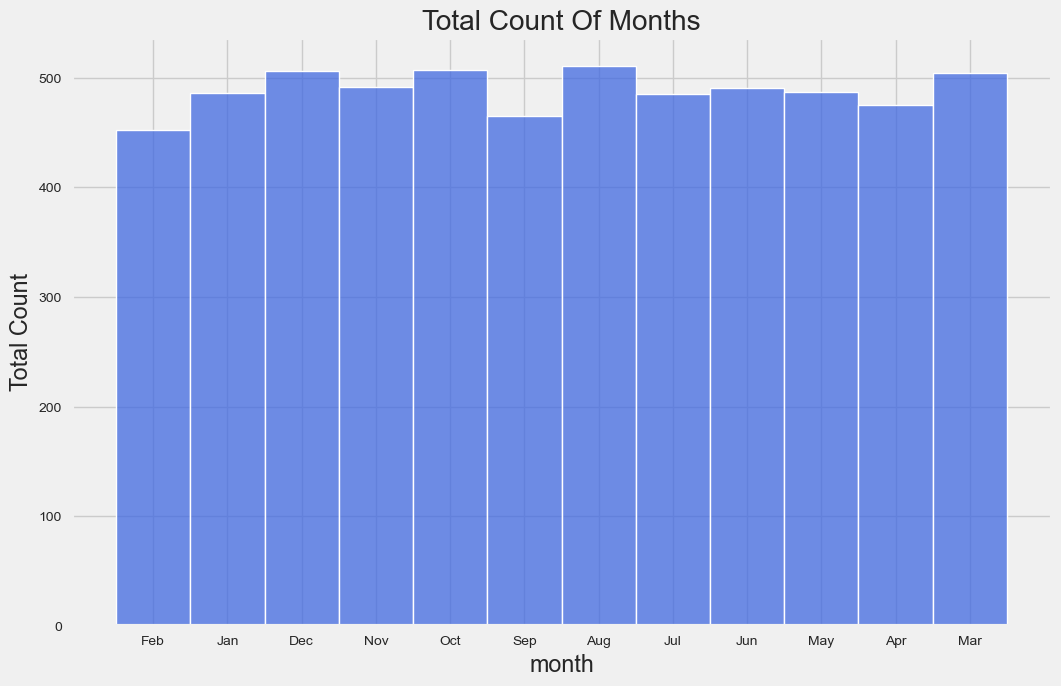

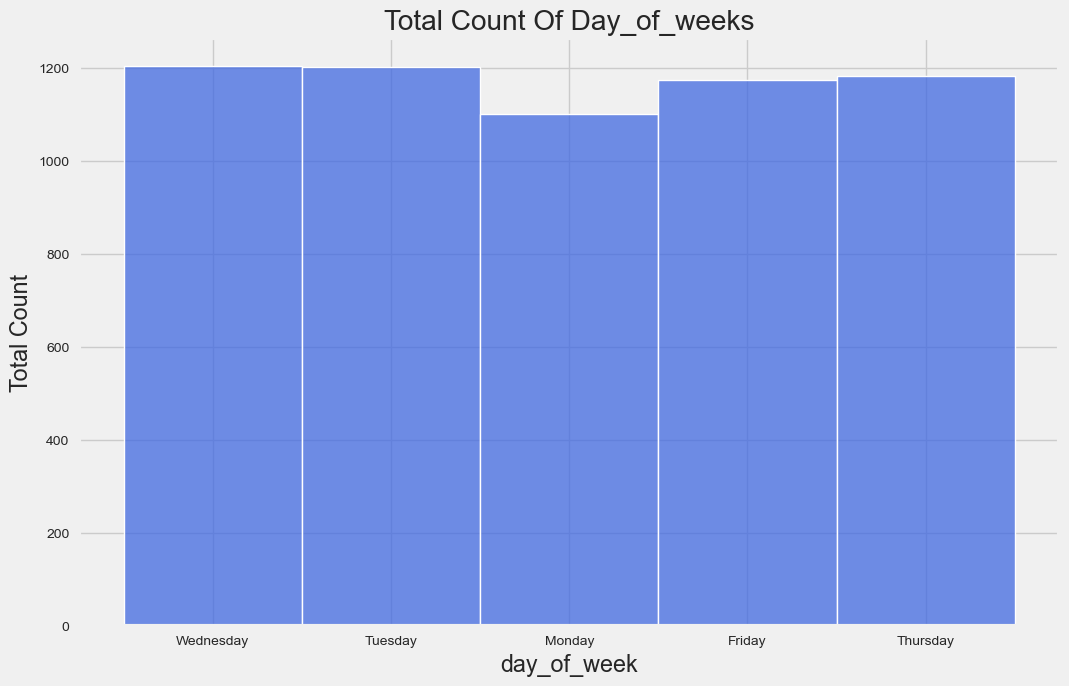

In [470]:
    cols = ['month', 'day_of_week']
    for col in cols:
        plt.style.use('_mpl-gallery')

        # plot:
        plt.figure(figsize=(10,6))
        sns.histplot(df[col], bins=25, color='royalblue', ec='white', linewidth=1)
        plt.title(f'Total Count Of {col.capitalize().strip("_")}'+'s')
        plt.ylabel("Total Count")
        plt.show()

<AxesSubplot: title={'center': 'plot'}>

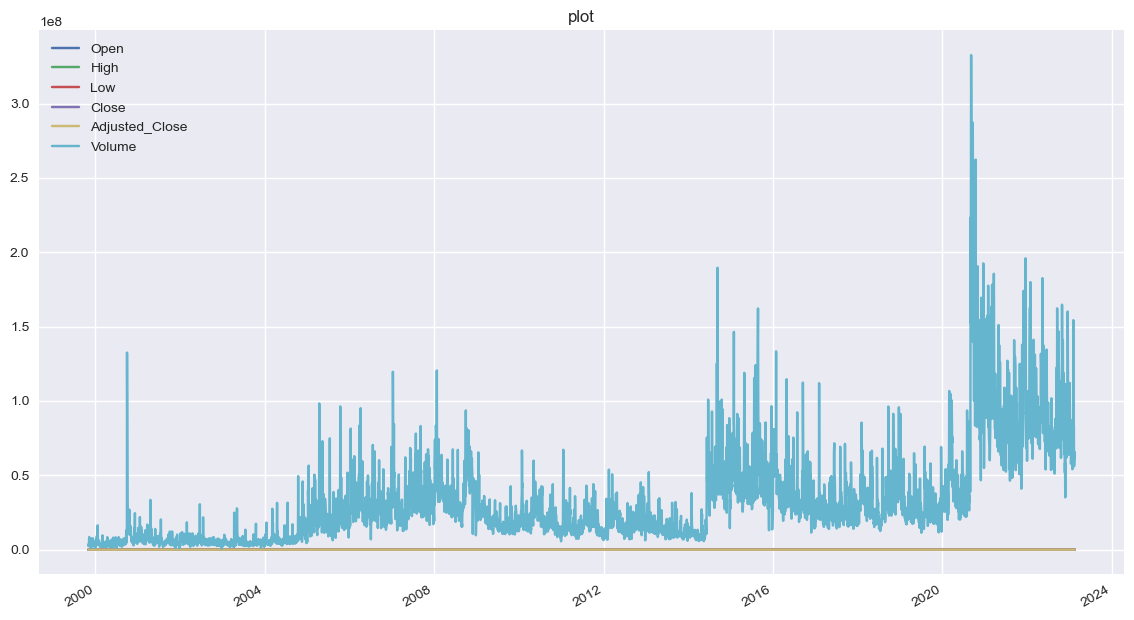

In [28]:
df.plot(figsize=(14,8), title='plot')

In [473]:
def adfuller_test(df):
    series = df['Close'].values
    series
    result = adfuller(series, autolag='AIC')

    print('ADF Statistic: %f' % result[0])

    print('p-value: %f' % result[1])

    print('Critical Values:')

    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if result[0] < result[4]["5%"]:
        print ("Reject Ho - Time Series is Stationary")
    else:
        print ("Failed to Reject Ho - Time Series is Non-Stationary")

In [413]:
def plot6(df):
    roc_df = df[['Close']]

    roc_df['Close_Shift']=roc_df.Close.shift(-1)

    roc_df['Variance']= roc_df.Close-roc_df.Close_Shift

    roc_df['roc']= roc_df.Variance/roc_df.Close_Shift*100
    plt.figure(figsize=(10,6))
    roc_df[['Close']].plot(color='seagreen', fontsize=12)
    plt.title("Close Price: AAPL", fontsize= 14)
    plt.xlabel("Year", fontsize=12)
    plt.ylabel("Close Price", fontsize=12)
    plt.legend(fontsize=12)
    plt.show()

    plt.title("ROC Close: AAPL", fontsize= 14)
    plt.xlabel("Year", fontsize=12)
    plt.ylabel("Percentage of Change", fontsize=12)
    roc_df['roc'].plot(color='rebeccapurple', label='ROC')
    plt.legend(fontsize=12)
    plt.figure(figsize=(10,6))
    plt.show()
    print("Highest Increase of Change within 1 Period:", round(roc_df['roc'].max(), 3))
    print("Highest Decrease of Change within 1 Period:", round(roc_df['roc'].min(),3))

# Percentage Based testing

In [ ]:
def train__val_test(df):
    '''
    Creating train, validate, test split.
    '''
    #Resample DataFrame to weeks sum.
    df_resampled = df.resample('W')[['Open','Close']].sum()

    # set train size to be 50% of total 
    train_size = int(round(df_resampled.shape[0] * 0.5))
    train_size

    # set validate size to be 30% of total 
    validate_size = int(round(df_resampled.shape[0] * 0.3))
    validate_size

    # set test size to be number of rows remaining. 
    test_size = int(round(df_resampled.shape[0] * 0.2))
    test_size
    
    #Checking to see if resample is equal length of splitting data.
    len(df_resampled) == train_size + validate_size + test_size

    # validate index
    validate_end_index = train_size + validate_size
    validate_end_index
    #Creating Train sample
    train = df_resampled[:train_size]
    #Checking last dates of train
    train.tail()
    #Creating validate sample
    validate = df_resampled[train_size:validate_end_index]
    #Creating test sample
    test = df_resampled[validate_end_index:]
    #Shape of samples rows
    train.shape[0], validate.shape[0], test.shape[0]
    #Verifying the samples match the length.
    len(train) + len(validate) + len(test) == len(df_resampled)
    #print(df_resampled.head(1) == train.head(1))
    #pd.concat([test.tail(1), df_resampled.tail(1)])
    return train, validate, test

def plot_sample(train, validate, test):
    for col in train.columns:
        plt.figure(figsize=(14,8))
        plt.plot(train[col], color='#377eb8', label = 'Train')
        plt.plot(validate[col], color='#ff7f00', label = 'Validate')
        plt.plot(test[col], color='#4daf4a', label = 'Test')
        plt.legend()
        plt.ylabel(col)
        plt.title(col)
        plt.show()

sns.boxplot(data = train, y=train['Open'])

plt.plot(train.index, train['Open'])
plt.plot(validate.index, validate['Open'])
plt.plot(test.index, test['Open'])
plt.show()

def plot8(train):
    plt.figure(figsize=(12,6))
    plt.hist(train, label=["Open", "Close"], ec='white')
    plt.xlabel('Open/Close')
    plt.ylabel('Count')
    plt.title('Distribution of Target')
    plt.legend()
    plt.show()

df.groupby('month')['Close'].mean().plot.bar()
plt.xticks(rotation=20)
plt.show()

train.resample('W').min()['Close'].plot()
train.resample('W').mean()['Close'].plot()
train.resample('W').max()['Close'].plot()
plt.show()

train.resample('W').mean()['Close'].plot()

train.resample('W').max()['Close'].plot()

seasonal_df = train.groupby([train.index.year, train.index.month]).mean()

seasonal_df.head()

seasonal_df = df.groupby([df.index.year, df.index.month]).mean()

seasonal_df.drop(columns=['High', 'Open', 'Low'], inplace=True)

seasonal_df = seasonal_df.iloc[-67:]

seasonal_df.unstack(0)

train.groupby([train.index.year, train.index.month]).mean().unstack(0)

seasonal_df.unstack(0).plot()

plt.xticks(ticks=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
          labels = ['Jan',
                   'Feb',
                   'Mar', 
                   'Apr',
                   'May',
                   'Jun',
                   'Jul',
                   'Aug',
                   'Sep',
                   'Oct',
                   'Nov',
                   'Dec'])
plt.legend()
plt.show()

df['year']=df.index.year

df.shape

polar_df=df.iloc[:2392]

fig = px.line_polar(polar_df, r='Close', theta='month', 
                    color='year', line_close=True, 
                    title='Polar seasonal plot',
                    width=600, height=500, 
                    markers=True,
                   start_angle=45)
fig.show()

week_mean= train.resample('W').mean()

week_mean['shifted'] = week_mean['Close'].shift(-1)

week_mean['shifted']

plt.scatter(week_mean['Close'], week_mean['shifted'])
plt.xlabel('close this week')
plt.ylabel('close next week')
plt.show()

week_mean['half_year'] = week_mean['Close'].shift(-26)
week_mean.head()

plt.scatter(week_mean['Close'], week_mean['half_year'])
plt.xlabel('Close this week')
plt.ylabel('Close in half year')
plt.show()

pd.plotting.autocorrelation_plot(train.resample('W').mean())
plt.show()



decomposition = seasonal_decompose(train['Close'], 
                                   model='multiplicative', 
                                   period=7)
decomposition.plot();

def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1, color='#377eb8')
    plt.plot(validate[target_var], label='Validate', linewidth=1, color='#ff7f00')
    plt.plot(yhat_df[target_var], label='yhat', linewidth=2, color='#a65628')
    plt.legend()
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

# create an empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

# function to store the rmse so that we can compare
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

train['Close'][-1:][0]

# take the last item of close price and assign to variable
last_close = train['Close'][-1:][0]

# take the last open price and assign to variable
last_open = train['Open'][-1:][0]
last_open 

yhat_df = pd.DataFrame(
    {'Open': [last_open],
     'Close': [last_close]},
    index=validate.index)

yhat_df.head()

for col in train.columns:
    plot_and_eval(col)

# compute simple average of sales_total (from train data)
avg_close = round(train['Close'].mean(), 2)
avg_close

# compute simple average of quantity (from train data)
avg_open = round(train['Open'].mean(), 2)
avg_open

def make_baseline_predictions(open_predictions=None, close_predictions=None):
    yhat_df = pd.DataFrame({'Open': [open_predictions],
                           'Close': [close_predictions]},
                          index=validate.index)
    return yhat_df

yhat_df = make_baseline_predictions(avg_open, avg_close)

for col in train.columns:
    plot_and_eval(col)



for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                            target_var = col)
eval_df



period=30
train['Close'].rolling(period).mean()

train['Close'].rolling(period).mean()[-1]

# Saving the last 30 day moving average for each column
rolling_open = round(train['Open'].rolling(period).mean()[-1], 2)
rolling_close = round(train['Close'].rolling(period).mean()[-1], 2)
print(rolling_open, rolling_close)

yhat_df = make_baseline_predictions(rolling_open, rolling_close)
yhat_df.head()

for col in train.columns:
    plot_and_eval(col)

for col in train.columns:
    eval_df = append_eval_df(model_type = '30d_moving_avg', 
                            target_var = col)

eval_df

periods = [4, 12, 26, 52, 104]

for p in periods: 
    rolling_open = round(train['Open'].rolling(p).mean()[-1], 2)
    rolling_close = round(train['Close'].rolling(p).mean()[-1], 2)
    yhat_df = make_baseline_predictions(rolling_open, rolling_close)
    model_type = str(p) + '_day_moving_avg'
    for col in train.columns:
        eval_df = append_eval_df(model_type = model_type,
                                target_var = col)

eval_df

best_open_rmse = eval_df[eval_df.target_var == 'Open']['rmse'].min()

best_open_rmse

eval_df[eval_df.rmse == best_open_rmse]

best_close_total_rmse = eval_df[eval_df.target_var == 'Close']['rmse'].min()

eval_df[eval_df.rmse == best_close_total_rmse]

for col in train.columns:
    sm.tsa.seasonal_decompose(train[col].resample('W').mean()).plot()

col = 'Close' 
# create our Holt Object
model = Holt(train[col], exponential=False, damped=True)

# fit the Holt object
model = model.fit(optimized=True)

yhat_close_total = model.predict(start = validate.index[0],
                              end = validate.index[-1])

yhat_close_total

# doing this in a loop for each column
for col in train.columns:
    model = Holt(train[col], exponential=False, damped=True)
    model = model.fit(optimized=True)
    yhat_values = model.predict(start = validate.index[0],
                              end = validate.index[-1])
    yhat_df[col] = round(yhat_values, 2)

for col in train.columns:
    plot_and_eval(target_var = col)

for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_optimized', 
                            target_var = col)

eval_df.sort_values(by='rmse')

# Models for quantity
hst_open_fit1 = ExponentialSmoothing(train['Open'], seasonal_periods=52, trend='add', seasonal='add').fit()
hst_open_fit2 = ExponentialSmoothing(train['Open'], seasonal_periods=52, trend='add', seasonal='mul').fit()
hst_open_fit3 = ExponentialSmoothing(train['Open'], seasonal_periods=52, trend='add', seasonal='add', damped=True).fit()
hst_open_fit4 = ExponentialSmoothing(train['Open'], seasonal_periods=52, trend='add', seasonal='mul', damped=True).fit()

# Models for sales
hst_close_fit1 = ExponentialSmoothing(train['Close'], seasonal_periods=52, trend='add', seasonal='add').fit()
hst_close_fit2 = ExponentialSmoothing(train['Close'], seasonal_periods=52, trend='add', seasonal='mul').fit()
hst_close_fit3 = ExponentialSmoothing(train['Close'], seasonal_periods=52, trend='add', seasonal='add', damped=True).fit()
hst_close_fit4 = ExponentialSmoothing(train['Close'], seasonal_periods=52, trend='add', seasonal='mul', damped=True).fit()

results_open=pd.DataFrame({'model':['hst_open_fit1', 'hst_open_fit2', 'hst_open_fit3', 'hst_open_fit4'],
                              'SSE':[hst_open_fit1.sse, hst_open_fit2.sse, hst_open_fit3.sse, hst_open_fit4.sse]})
results_open

results_open.sort_values(by='SSE')

results_close=pd.DataFrame({'model':['hst_close_fit1', 'hst_close_fit2', 'hst_close_fit3', 'hst_close_fit4'],
                              'SSE':[hst_close_fit1.sse, hst_close_fit2.sse, hst_close_fit3.sse, hst_close_fit4.sse]})
results_close

results_close.sort_values(by='SSE')

yhat_df = pd.DataFrame({'Open': hst_open_fit1.forecast(validate.shape[0]),
                           'Close': hst_close_fit3.forecast(validate.shape[0])},
                          index=validate.index)
yhat_df

for col in train.columns:
    plot_and_eval(col)

eval_df

for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_seasonal_add_add', 
                            target_var = col)

eval_df.sort_values(by='rmse')

train = df_resampled[:'2016']
validate = df_resampled[:'2017']
test = df_resampled[':2018']

print(train.shape)
print(validate.shape)
print(test.shape)

train.head()
train.tail()

train.diff(365)

yhat_df = train['2016'] + train.diff(365).mean()
yhat_df

train.loc['2016'].head()

pd.concat([yhat_df.head(1), validate.head(1)])

train.loc['2016'].head()

yhat_df.shape

yhat_df

validate.shape

validate = validate[validate.index != '2017-12-31']

yhat_df.index = validate.index

for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = "previous_year", 
                            target_var = col)



eval_df.sort_values(by='rmse')

open_total_min_rmse = eval_df.groupby('target_var')['rmse'].min()[0]

close_min_rmse = eval_df.groupby('target_var')['rmse'].min()[1]

# find which model that is
eval_df[((eval_df.rmse == open_total_min_rmse) | 
         (eval_df.rmse == close_min_rmse))]

train = df_resampled[:train_size]
validate = df_resampled[train_size:validate_end_index]
test = df_resampled[validate_end_index:]



train.shape, validate.shape, test.shape

yhat_df = pd.DataFrame({'Open': hst_open_fit1.forecast(validate.shape[0] + test.shape[0]),
                           'Close': hst_close_fit3.forecast(validate.shape[0] + test.shape[0])})
yhat_df

validate.head(1)

test.head(1)

yhat_df = yhat_df['2018-07-01':]

def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], color='#377eb8', label='train')
    plt.plot(validate[target_var], color='#ff7f00', label='validate')
    plt.plot(test[target_var], color='#4daf4a',label='test')
    plt.plot(yhat_df[target_var], color='#a65628', label='yhat')
    plt.legend()
    plt.title(target_var)
    plt.show()

yhat_df

rmse_open_total = sqrt(mean_squared_error(test['Open'], 
                                       yhat_df['Open']))

rmse_close = sqrt(mean_squared_error(test['Close'], 
                                       yhat_df['Close']))

print('FINAL PERFORMANCE OF MODEL ON TEST DATA')
print('rmse-open total: ', rmse_open_total)
print('rmse-close: ', rmse_close)
for col in train.columns:
    final_plot(col)

forecast = pd.DataFrame({'Open': hst_open_fit1.forecast(validate.shape[0] + test.shape[0] + 365),
                           'Close': hst_close_fit3.forecast(validate.shape[0] + test.shape[0] + 365)})
forecast = forecast['2022':]
forecast

def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], color='#377eb8', label='Train')
    plt.plot(validate[target_var], color='#ff7f00', label='Validate')
    plt.plot(test[target_var], color='#4daf4a', label='Test')
    plt.plot(yhat_df[target_var], color='#a65628', label='yhat')
    plt.plot(forecast[target_var], color='#984ea3', label='Forecast')
    plt.title(target_var)
    plt.legend()
    plt.show()

for col in train.columns:
    final_plot(col)